In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# this is just to know how much time will it take to run this entire ipython notebook 
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/edsa-recommender-system-predict/tags.csv
/kaggle/input/edsa-recommender-system-predict/train.csv
/kaggle/input/edsa-recommender-system-predict/genome_scores.csv
/kaggle/input/edsa-recommender-system-predict/genome_tags.csv
/kaggle/input/edsa-recommender-system-predict/movies.csv
/kaggle/input/edsa-recommender-system-predict/imdb_data.csv
/kaggle/input/edsa-recommender-system-predict/test.csv
/kaggle/input/edsa-recommender-system-predict/links.csv
/kaggle/input/edsa-recommender-system-predict/sample_submission.csv


In [18]:
train = pd.read_csv(r'../input/edsa-recommender-system-predict/train.csv')
tags = pd.read_csv(r'../input/edsa-recommender-system-predict/tags.csv')
genome = pd.read_csv(r'../input/edsa-recommender-system-predict/genome_scores.csv')
test = pd.read_csv(r'../input/edsa-recommender-system-predict/test.csv')
imdb = pd.read_csv(r'../input/edsa-recommender-system-predict/imdb_data.csv')
movies = pd.read_csv(r'../input/edsa-recommender-system-predict/movies.csv')
links = pd.read_csv(r'../input/edsa-recommender-system-predict/links.csv')
test = pd.read_csv(r'../input/edsa-recommender-system-predict/test.csv')
ss = pd.read_csv(r'../input/edsa-recommender-system-predict/sample_submission.csv')

In [19]:
train.head(5)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739


In [53]:
movies.tail(5)

,movieId,title,genres
62373,208933,The Devil's Partner (1961),Horror
62374,208939,Klaus (2019),Adventure|Animation|Children|Comedy
62375,208941,"Maria, Mirabella (1981)",Animation|Children|Comedy
62376,208943,Acceleration (2019),(no genres listed)
62377,208945,Powder (2019),Comedy|Drama
62378,208955,Nadide's Life (2015),Comedy|Drama
62379,208967,Ochberg's Orphans (2008),(no genres listed)
62380,208973,The Falklands War: The Untold Story,(no genres listed)
62381,209005,Paris The Luminous Years (2010),Documentary
62382,209007,The Queen of Trees (2005),Documentary|Drama


In [21]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(train.isnull().any()))

No of Nan values in our dataframe :  0


In [22]:
train.describe()['rating']

count    1.000004e+07
mean     3.533395e+00
std      1.061124e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [23]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",train.shape[0])
print("Total No of Users   :", len(np.unique(train.userId)))
print("Total No of movies  :", len(np.unique(train.movieId)))

Total data 
--------------------------------------------------

Total no of ratings : 10000038
Total No of Users   : 162541
Total No of movies  : 48213


In [24]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<IPython.core.display.Javascript object>


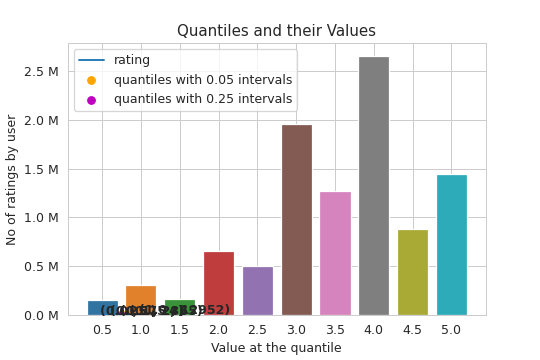

In [25]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

In [26]:
no_of_rated_movies_per_user = train.groupby(by='userId')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
Name: rating, dtype: int64

In [27]:
no_of_rated_movies_per_user.describe()

count    162541.000000
mean         61.523173
std         107.410889
min           1.000000
25%          14.000000
50%          28.000000
75%          65.000000
max       12952.000000
Name: rating, dtype: float64

<IPython.core.display.Javascript object>


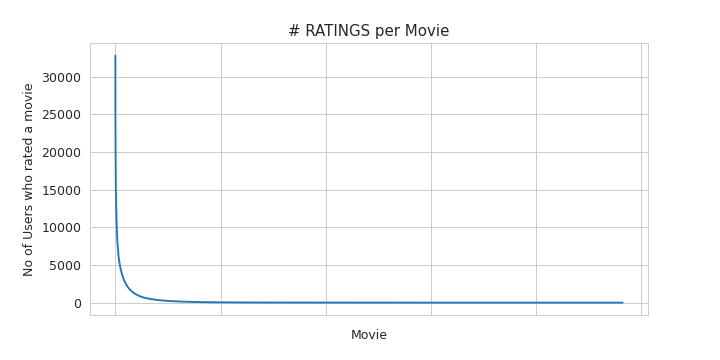

In [30]:
no_of_ratings_per_movie = train.groupby(by='movieId')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

In [31]:
movie_data = pd.merge(train, movies, on='movieId')

In [32]:
movie_data.head(2)

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [33]:
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Final Recourse (2013)        5.0
Lady and the Tramp (2019)    5.0
Virasat (1997)               5.0
Committed (2014)             5.0
Sole Proprietor (2016)       5.0
Name: rating, dtype: float64

In [34]:
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Shawshank Redemption, The (1994)    32831
Forrest Gump (1994)                 32383
Pulp Fiction (1994)                 31697
Silence of the Lambs, The (1991)    29444
Matrix, The (1999)                  29014
Name: rating, dtype: int64

In [35]:
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())

In [36]:
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())

In [37]:
ratings_mean_count.head()

,rating,rating_counts
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.753731,67
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


You can see movie title, along with the average rating and number of ratings for the movie.

Let's plot a histogram for the number of ratings represented by the "rating_counts" column in the above dataframe

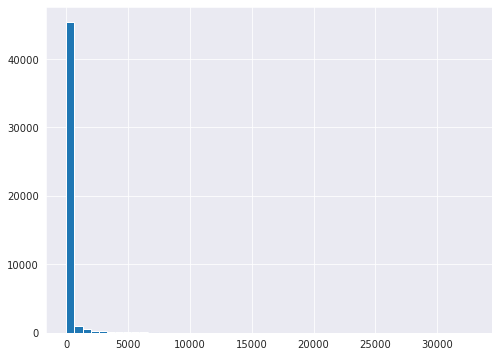

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

From the output, you can see that most of the movies have received less than 50 ratings. While the number of movies having more than 5000 ratings is very low.

Now we'll plot a histogram for average ratings

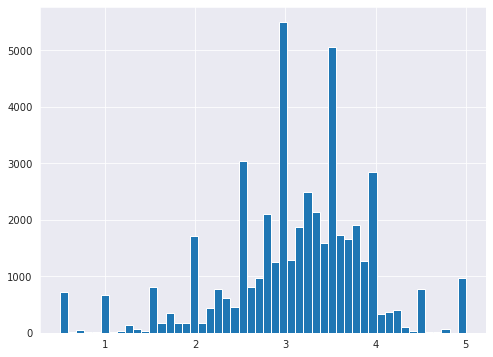

In [39]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

You can see that the integer values have taller bars than the floating values since most of the users assign rating as integer value i.e. 1, 2, 3, 4 or 5. Furthermore, it is evident that the data has a weak normal distribution with the mean of around 3.5. There are a few outliers in the data.

We will plot average ratings against the number of ratings:

<Figure size 576x432 with 0 Axes>

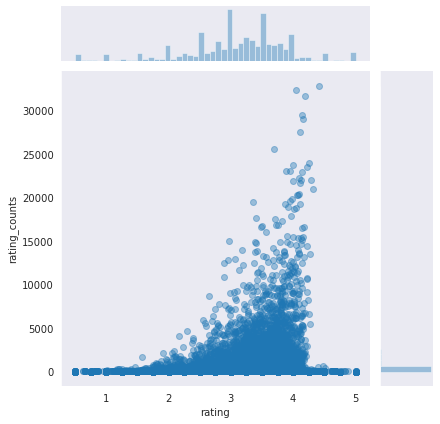

In [40]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

The graph shows that, in general, movies with higher average ratings actually have more number of ratings, compared with movies that have lower average ratings.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using TF-IDF
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Filling NaNs with empty string
imdb['plot_keywords'] = imdb['plot_keywords'].fillna('')

# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(imdb['plot_keywords'])

tfv_matrix.shape

(27278, 9461)

In [42]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

# Reverse mapping of indices and movie titles
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

# Credit to Ibtesam Ahmed for the skeleton code
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return movies['title'].iloc[movie_indices]

In [56]:
# Testing our content-based recommendation system with the seminal film Spy Kid
give_rec('Spy Kids (2001)')

1                         Jumanji (1995)
2                Grumpier Old Men (1995)
3               Waiting to Exhale (1995)
4     Father of the Bride Part II (1995)
5                            Heat (1995)
6                         Sabrina (1995)
7                    Tom and Huck (1995)
8                    Sudden Death (1995)
9                       GoldenEye (1995)
10        American President, The (1995)
Name: title, dtype: object

This gives you a recommendation of movies that are like Toy Story. You can type any movie, it will give you a recommendation based on plot keywords